# Análisis de Componetes Principales

## Preliminares

In [3]:
from prody import *
from pylab import *

/home/joel/anaconda3/envs/mds/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


### Se carga el ensamble previamente generado


In [7]:
ensamble = loadEnsemble("./cdk2_crys_ensamble_385_CA.ens.npz")
len(ensamble)

385

### Pruebas con el ensamble

In [9]:
# Para obtener una conformación a aprtir del índice
ensamble.getConformation(39) # 1jsu
# ensamble.getConformation(372) # 5mhq; rehacer el modelo?

<PDBConformation: 1jsu_full_ca from Ensamble CDK2 pseudoNMR (index: 39; 298 atoms)>

#### Residuos definidos por Pisani (2015) para su análisis

Para hacer el ensamble y alinear las estructuras en una *"trayectoria"* se definen los residuos que se tomaran en cuenta para el alineamiento:  
**PISANNI**: son los residuos usados por Pisiani en su artículo prara alinear las estructuras.

In [8]:
from itertools import chain

'''This list of residues was characterized as the subset of residues that contains 
the largest part of the information about the structural variability of CDK2 
and includes residues of R-spine (except for Met 196), C-spine, DFG, and the catalytic loop.'''

pisiani_rangeResidues = [ [4,12], [17, 24], [29,34], [46,55], [66,71], [76,81],  
                         [87,93], [101, 120], [121, 135], [140, 150], [182, 194], [277, 282]]

lista = [list( range(valor[0], valor[1]) ) for valor in pisiani_rangeResidues]

# Se obtiene la lista de residuos, incluida en formato de cadena de texto
pisiani_residues = list(chain.from_iterable(lista))
pisiani_residues_str = ' '.join(str(e) for e in pisiani_residues)

print(pisiani_residues_str)

4 5 6 7 8 9 10 11 17 18 19 20 21 22 23 29 30 31 32 33 46 47 48 49 50 51 52 53 54 66 67 68 69 70 76 77 78 79 80 87 88 89 90 91 92 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 121 122 123 124 125 126 127 128 129 130 131 132 133 134 140 141 142 143 144 145 146 147 148 149 182 183 184 185 186 187 188 189 190 191 192 193 277 278 279 280 281


**RICCI**: Son residuos definidos a partir de la estructura 4fkw, del dataset de CSAR. Se definen al identificar todos los residuos que están dentro de 7 A de distancia de cualquier átomo del ligando cocristalizado, ubicado en la cavidad catalítica de la CDK2.

In [21]:
# Pocket (4FKW y su ligando a 7 A): 8-19, 30-33, 64-65, 79-90, 129-134, 143-146
# resid 8 to 19 30 to 33 64 65 79 to 90 129 to 134 143 to 146
ricci_rangeResidues = [[8,19], [30,33], [64,65], [79,90], [129,134], [143,146]]

lista = [list( range(valor[0], valor[1]) ) for valor in ricci_rangeResidues]
ricci_residues = list(chain.from_iterable(lista))
ricci_residues_str = ' '.join(str(e) for e in ricci_residues)

print(ricci_residues_str)

8 9 10 11 12 13 14 15 16 17 18 30 31 32 64 79 80 81 82 83 84 85 86 87 88 89 129 130 131 132 133 143 144 145


# Análisis de componentes principales

## 1) PCA: Prody

In [9]:
# Instancia del PCA
#ensamble.superpose()
pca_prody = PCA("385 CDK2 Prody")

# Se obtiene la matriz de covarianzas
pca_prody.buildCovariance(ensamble)

# Se calculan los eginvectores
pca_prody.calcModes()

@> Covariance is calculated using 385 coordinate sets.
@> Covariance matrix calculated in 0.497094s.
@> 20 modes were calculated in 0.42s.


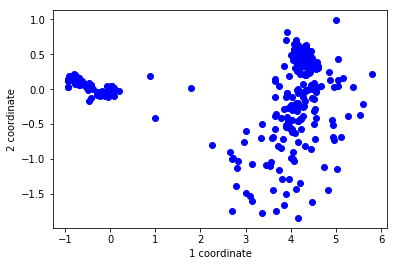

In [10]:
showProjection(ensamble, pca_prody[:2]);

## 2) PCA: pytraj y sklearn

In [11]:
import pytraj as pt
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [13]:
# Se carga el archivo pdb del ensamble
traj = pt.load("./cdk2_crys_ensamble_385_CA.pdb")
traj

pytraj.Trajectory, 385 frames: 
Size: 0.002564 (GB)
<Topology: 298 atoms, 298 residues, 298 mols, non-PBC>
           

In [16]:
# Se instancia un PCA de sklearn
# Se inicializa con los parámetros por default
pca = PCA(copy=True, n_components= 2)
pca

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [18]:
# La matriz de corrdedandas es una matriz de tres dimensiones
shape(traj.xyz)

(385, 298, 3)

In [19]:
# Se obtiene la matriz n*m de conformaciones y coordenadas (n= # conf y m = #de átomos * 3)
xyz_2d = traj.xyz.reshape(traj.n_frames, traj.n_atoms * 3)
# La matriz posee 385 conformaciones y 849 coordenadas (894/3 = 298 CA átomos)
xyz_2d.shape

(385, 894)

In [20]:
# Se ajusta el modelo, fit_transform estandariza los valores de la matriz y
# después realiza el ajuste
reduced_cartesian = pca.fit_transform(xyz_2d)

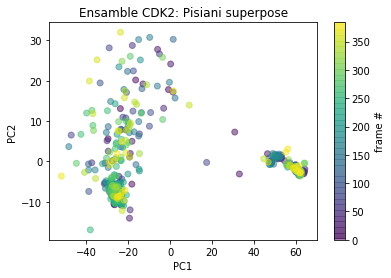

In [141]:
# Observamos la distribución de las conformaciones en función de las primeros
# dos PCs
import warnings
warnings.filterwarnings('ignore')

plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], 
            marker='o', c=range(traj.n_frames), alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("Ensamble CDK2: Pisiani superpose")
cbar = plt.colorbar()
cbar.set_label('frame #')

In [34]:
# Comapro los PCS
reduced_cartesian[:,1]


array([13.08621927, -8.94769035, -6.78224577, ..., -2.86463284,
        0.24277417,  1.97749893])

In [36]:
pca_prody.getCovariance()

array([[ 2.08129568, -0.6967471 ,  0.94488754, ...,  0.2861791 ,
         0.07553196, -0.25467529],
       [-0.6967471 ,  0.76696529, -0.25826519, ..., -0.26053523,
         0.0512905 ,  0.22533794],
       [ 0.94488754, -0.25826519,  3.87013237, ...,  1.04382783,
        -1.85601178, -1.44261594],
       ...,
       [ 0.2861791 , -0.26053523,  1.04382783, ..., 13.38291784,
        -5.24217287,  1.32735562],
       [ 0.07553196,  0.0512905 , -1.85601178, ..., -5.24217287,
         9.80396022,  1.80666102],
       [-0.25467529,  0.22533794, -1.44261594, ...,  1.32735562,
         1.80666102,  3.06337324]])

### PCA usando superpose para la "trayectoria"
En el caso de abajo el ensamble es alineado nuevamente usando el método superpose(), que por defecto debería tomar en cuenta toda la estructura de la proteína para minimizar la matriz de RMSD. Recordar que el ensamble guardado originalmente con prody está alineado usando los residuos de Pisani.

(387, 894)
[0.69569318 0.04673942]


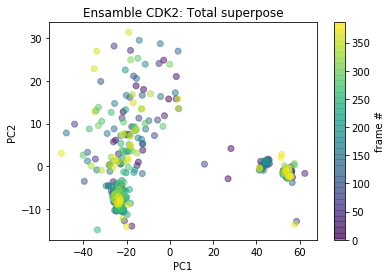

In [4]:
traj_2 = pt.load("./cdk2_crys_ensamble_387_CA.pdb")

pca_2 = PCA(copy=True, iterated_power='auto', n_components= 2, random_state= None,
   svd_solver= 'auto', tol= 0.0, whiten= False)

traj_2 = traj_2.superpose()
xyz_2d_2 = traj_2.xyz.reshape(traj_2.n_frames, traj_2.n_atoms * 3)
print(xyz_2d_2.shape)

reduced_cartesian_2 = pca_2.fit_transform(xyz_2d_2)

print(pca_2.explained_variance_ratio_) # Porcentaje de varianza explicada

plt.figure()
plt.scatter(reduced_cartesian_2[:, 0], reduced_cartesian_2[:,1],
            marker='o', c=range(traj_2.n_frames), alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("Ensamble CDK2: Total superpose")
cbar = plt.colorbar()
cbar.set_label('frame #')

In [ ]:
# Queda pendiente garegar una gráfica añadiendo las conformaciones conocidas activa, dfg-out, etc

### Proyectando un conjunto de datos al subespacio ya definido
Ahora comparamos los dos conjuntos de datos (ensamble alineado por Pisiani, y alineado total). Más que nada como una manera de probar cómo protyectar nuevos datos a un subespacio ya definido.

In [ ]:
# PRENDIENTE

## 3) PCA: Forma manual

[//]: # http://www.fuenterrebollo.com/Economicas/ECONOMETRIA/MULTIVARIANTE/ACP/ACP.pdf, http://www.ub.edu/stat/docencia/Mates/ejemploACP.PDF, 
https://sebastianraschka.com/Articles/2014_pca_step_by_step.html#2-computing-the-d-dimensional-mean-vector


Se considera una serie de $m$ variables (coordenadas: $({x_1, x_2, .., x_m})$ sobre un grupo de $n$ individuos u observaciones (conformaciones) y se trata de calcular, a partir de ellos, un nuevo conjunto de variables (${w_1, w_2, .., w_j, .., w_m}$), incorreladas entre sí (ortogonales), cuyas varianzas van decreciendo progresivamente desde el primer CP al CP $m$.

Por lo tanto, cada $w_j$, con $j\in{1, .., m}$ es una combinación lineal de las (${x_1, x_2, .., x_m}$) originales, es decir:
$$ \mathbf{w_j} = a_{j1}·x_1 +  a_{j2}·x_2 + ... + a_{jm}·x_m, $$
o, de otro modo
$$ \mathbf{w_j} = a^o_j·\mathbf{x}, $$
donde $a^o_j$ esun vector de constantes $a^o_j = (a_{j1}, a_{j2}, .., a_{jm})$ y $\mathbf{x} = ({x_1, x_2, .., x_m})$ transpuesto.

Debido a que lo que se busca es maximizar la varianza de cada CP ($w_j$), una alternativa podría ser aumentar indefinidamente los valores de su vector $a^o_{j}$. Por lo tanto, para mantener la ortogonalidad de la transformación, se impone que el módulo del vector (distancia euclídea) sea igualado a 1.



In [41]:
# Se obtiene la trayectoria
traj_m = pt.load("./cdk2_crys_ensamble_385_CA.pdb")

# Se necesitan las coordenadas XYZ de la trayectoria
print("Matriz de coordenadas original:", traj_m.xyz.shape, " y es de tipo: ", 
      type(traj_m.xyz.shape))
# La trayectoria está representada en una matriz de 3 dimensiones
# Para hacer el trabajo se requiere una matriz de dos dimensiones

Matriz de coordenadas original: (385, 298, 3)  y es de tipo:  <class 'tuple'>


Se transforma la matriz a dos dimensiones.

In [42]:
# Se transforma la matriz a dos dimensiones y a una matriz de numpy
# # de columnas = num de frames, filas = num de coordenadas (átomos * 3)
xyz_2d_m = traj_m.xyz.reshape(traj_m.n_frames, traj_m.n_atoms * 3)

print("Matriz de coordenadas en 2d:", xyz_2d_m.shape, " y es de tipo: ", type(xyz_2d_m))

Matriz de coordenadas en 2d: (385, 894)  y es de tipo:  <class 'numpy.ndarray'>


### 0) Preliminares
#### ¿Se justifica el uso de un PCA?
[//]: <http://www.ub.edu/stat/docencia/Mates/ejemploACP.PDF>
Antes de aplicar el PCA hay que verificar si es necesario o beneficioso hacerlo, es decir, si la correlación (medida normalizada de la covarianza $r_{kj} = cov(k,j)/sd_k*sd_j$) entre las variables es lo suficientemente grande como para justificar la factorización de la matriz de correlaciones.  
Para ello podemos hacer un test de Barlett cuya $H_0$ es que la matriz de covarianzas de las variables no es significativamente distinta a la matriz de identidad, es decir que para cada para de variables $j$ y $k$, donde $j \neq k$, se tiene que $H_0=cov(j,k) = 0$.

In [ ]:
#### PENDIENTE

### 1) Estandarización de los datos
El PCA se ve afectado por la escala de las variables. Aunque en este caso la escala es la misma para todas las coordenadas; todas están en A, procedo a estandarizar cada dato $i$ para cada variable (coordenada) $x_j$:
$$z_{ji} = \frac{(x_{ji} - \mu_{j})} {sd_{j}} $$

#### Valores originales

In [43]:
# Valores originales
xyz_2d_m

array([[-13.743, 190.22 , 105.029, ...,   2.111, 214.475, 105.893],
       [-12.923, 190.677, 105.77 , ...,   0.722, 213.462, 107.978],
       [-13.83 , 190.927, 106.109, ...,   0.609, 213.291, 108.16 ],
       ...,
       [-13.124, 190.884, 102.087, ...,  -1.863, 214.657, 110.513],
       [-10.753, 190.359, 106.61 , ...,   0.698, 213.412, 108.038],
       [-10.593, 190.352, 106.158, ...,   0.849, 213.835, 108.759]])

#### Valores estandarizados

In [44]:
# SOLO como ejercicio didáctico: Estandarización con numpy
# z = (xi - u) / sd
(xyz_2d_m - np.mean(xyz_2d_m, axis=0) ) / np.std(xyz_2d_m, axis=0) 
# Especificando la operación por columna con axis = 0
# No los guardo en una variable porque usaré el método de sklearn unas celdas más abajo

array([[-0.94265087, -0.27957182, -0.01149977, ...,  0.45659488,
        -0.13195212, -1.83434245],
       [-0.37425311,  0.24226374,  0.36516066, ...,  0.07690914,
        -0.4554781 , -0.64307945],
       [-1.00295649,  0.52773178,  0.537479  , ...,  0.04602038,
        -0.51009108, -0.5390939 ],
       ...,
       [-0.51357988,  0.47863128, -1.5069586 , ..., -0.62970542,
        -0.07382602,  0.80529067],
       [ 1.12992146, -0.12085159,  0.79214415, ...,  0.0703487 ,
        -0.47144681, -0.6087985 ],
       [ 1.24082834, -0.1288447 ,  0.56238637, ...,  0.11162483,
        -0.33635156, -0.19685576]])

In [46]:
# Mejor aún, guardo los valores en variables para usarlos más tarde
vec_means_var = np.mean(xyz_2d_m, axis=0)
vec_sd_var = np.std(xyz_2d_m, axis=0)
print("Número de variables: ", len(vec_means_var))

Número de variables:  894


#### Estandarización con sklearn.preprocessing.StandarScale

In [47]:
# Estandarización con sk.learn
from sklearn.preprocessing import StandardScaler
xyz_std = StandardScaler().fit_transform( xyz_2d_m )
# Valores transformados
xyz_std

array([[-0.94265087, -0.27957182, -0.01149977, ...,  0.45659488,
        -0.13195212, -1.83434245],
       [-0.37425311,  0.24226374,  0.36516066, ...,  0.07690914,
        -0.4554781 , -0.64307945],
       [-1.00295649,  0.52773178,  0.537479  , ...,  0.04602038,
        -0.51009108, -0.5390939 ],
       ...,
       [-0.51357988,  0.47863128, -1.5069586 , ..., -0.62970542,
        -0.07382602,  0.80529067],
       [ 1.12992146, -0.12085159,  0.79214415, ...,  0.0703487 ,
        -0.47144681, -0.6087985 ],
       [ 1.24082834, -0.1288447 ,  0.56238637, ...,  0.11162483,
        -0.33635156, -0.19685576]])

In [48]:
shape(xyz_std)

(385, 894)

### 2) Cálculo de la matriz de covarianza
La covarianza $\sigma_{kj}$ entre dos variables $k$ y $j$ se calcula de la siguiente manera:
$$ \sigma_{kj} = \frac{1}{n-1} \sum_{i=1}^{n}\left(x_{ik} - \bar{x_k}\right)\left(x_{ij}-\bar{x_j}\right)$$
Es la sumatoria del producto de las diferencias de cada observación $i$ de las variables $k$ y $j$ con respecto a su media, dividido entre el número de observaciones $n$ menos uno. 

En la representación matricial es equivalente a la matriz $\Sigma$:
$$\Sigma = \frac{1}{n-1} \left( (\mathbf{X} - \mathbf{\bar{x}})^T\;(\mathbf{X} - \mathbf{\bar{x}}) \right)$$

Con lo cual la matriz de covarianzas $\Sigma$ es bidimensional de tamaño $m*m$, con $m$ = número de variables (# átomos * 3). Y el vector $\mathbf{\bar{x}}$, es el vector de medias de todas las $m$ variables.

In [102]:
# Para ir con la nomenclatura.
X_std = xyz_std

# Cálculo del vector de medias
vec_medias = np.mean(X_std)

# Número de observaciones
num_obs = X_std.shape[0]

# Cálculo de la matriz de covarianzas
( 1 / ( num_obs - 1 )  ) * ( ( xyz_std -  vec_medias).T.dot( xyz_std -  vec_medias))

array([[ 1.00260417, -0.55291156,  0.33379766, ...,  0.05437938,
         0.01676804, -0.10111081],
       [-0.55291156,  1.00260417, -0.15029561, ..., -0.08152539,
         0.01875559,  0.14739693],
       [ 0.33379766, -0.15029561,  1.00260417, ...,  0.14541536,
        -0.30210334, -0.42006361],
       ...,
       [ 0.05437938, -0.08152539,  0.14541536, ...,  1.00260417,
        -0.45884391,  0.20784092],
       [ 0.01676804,  0.01875559, -0.30210334, ..., -0.45884391,
         1.00260417,  0.33051904],
       [-0.10111081,  0.14739693, -0.42006361, ...,  0.20784092,
         0.33051904,  1.00260417]])

In [50]:
# Versión simple usando numpy
cov_mtx = np.cov(X_std.T)
cov_mtx

array([[ 1.00260417, -0.55291156,  0.33379766, ...,  0.05437938,
         0.01676804, -0.10111081],
       [-0.55291156,  1.00260417, -0.15029561, ..., -0.08152539,
         0.01875559,  0.14739693],
       [ 0.33379766, -0.15029561,  1.00260417, ...,  0.14541536,
        -0.30210334, -0.42006361],
       ...,
       [ 0.05437938, -0.08152539,  0.14541536, ...,  1.00260417,
        -0.45884391,  0.20784092],
       [ 0.01676804,  0.01875559, -0.30210334, ..., -0.45884391,
         1.00260417,  0.33051904],
       [-0.10111081,  0.14739693, -0.42006361, ...,  0.20784092,
         0.33051904,  1.00260417]])

### 3) Cálculo de los egeinvectores y egeinvalores (vectores y valores propios)
#### Planteamiento
Si A es una matriz de $m*m$, hay $x$ vectores diferentes de cero en $R^n$ tales que $A·x$ sea un múltiplo escalar de $x$.

In [54]:
eig_val_cov, eig_vec_cov = np.linalg.eig(cov_mtx)
len(eig_val_sc)

894

In [77]:
for i in range(len(eig_val_cov)):
    eigv = eig_vec_cov[:,i].reshape(1, len(eig_val_sc) ).T
    np.testing.assert_array_almost_equal(cov_mtx.dot(eigv), eig_val_cov[i] * eigv,
                                         decimal=6, err_msg='', verbose=True)

In [79]:
eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:,i]) for i in range(len(eig_val_cov))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
for i in eig_pairs:
    print(i[0])

490.58319150394
79.28487427928455
43.38196331100605
25.477709224138685
24.33562081070447
19.0051856239982
17.59968549908563
15.116781127498298
13.150053515483762
10.171525727569035
9.128082704696634
7.778452148629314
7.604852207315408
5.9007643579673354
5.5412266899863445
4.994951302719222
4.713974748928956
4.58199092562698
3.891624987887607
3.5638915043903934
3.431466434455211
3.2628437506401498
3.1727056689779274
2.9391141484937626
2.8273980905329252
2.570539474299579
2.460076751060265
2.429676874768146
2.185589077727886
2.0824462566367012
1.9440150426271905
1.8344273216277487
1.794709054360855
1.7086448969778236
1.6239764569304678
1.5752117642688253
1.5307416736785164
1.456056732679972
1.4011916892735825
1.3458793729487206
1.3358795882796157
1.2837172474902239
1.2350132918460996
1.1122935282306823
1.0654746634585928
1.0312418406906803
1.0015474873700858
0.9840148079855677
0.9615106974923661
0.9271707461701365
0.9188522900741567
0.8831447258908643
0.8399107058185599
0.822368287376497

In [91]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(894,1), eig_pairs[1][1].reshape(894,1)))
print('Matriz W:\n', matrix_w)

Matriz W:
 [[ 0.01116588+0.j  0.00107094+0.j]
 [-0.01427162+0.j -0.0186116 +0.j]
 [ 0.03743484+0.j  0.00311151+0.j]
 ...
 [ 0.0061793 +0.j  0.01823255+0.j]
 [-0.01671963+0.j -0.00204627+0.j]
 [-0.0235768 +0.j  0.0004078 +0.j]]


In [113]:
shape((eig_pairs[0][1].reshape(894,1)))

(894, 1)

In [110]:
eig_pairs[0][1]

array([ 0.01116588+0.j, -0.01427162+0.j,  0.03743484+0.j, ...,
        0.0061793 +0.j, -0.01671963+0.j, -0.0235768 +0.j])

In [115]:
X_std.reshape(894,385)

array([[-0.94265087, -0.27957182, -0.01149977, ...,  2.24472889,
         2.16458121,  0.04354834],
       [ 2.9417264 ,  0.83442469,  0.14878309, ..., -0.47230487,
        -0.39260492,  0.79014776],
       [-0.27095371, -0.41138486,  2.00190741, ...,  0.51487864,
        -0.27654667,  0.06121542],
       ...,
       [ 0.32721847, -0.63354287, -1.2040875 , ...,  1.73700184,
         2.70266235, -2.23872773],
       [ 1.91670605,  2.48159714, -2.17749392, ..., -0.39303553,
         0.4570616 , -0.52570939],
       [-0.02248401,  0.41949457, -0.5703633 , ...,  0.11162483,
        -0.33635156, -0.19685576]])

array([[-0.94265087, -0.27957182, -0.01149977, ...,  0.45659488,
        -0.13195212, -1.83434245],
       [-0.37425311,  0.24226374,  0.36516066, ...,  0.07690914,
        -0.4554781 , -0.64307945],
       [-1.00295649,  0.52773178,  0.537479  , ...,  0.04602038,
        -0.51009108, -0.5390939 ],
       ...,
       [-0.51357988,  0.47863128, -1.5069586 , ..., -0.62970542,
        -0.07382602,  0.80529067],
       [ 1.12992146, -0.12085159,  0.79214415, ...,  0.0703487 ,
        -0.47144681, -0.6087985 ],
       [ 1.24082834, -0.1288447 ,  0.56238637, ...,  0.11162483,
        -0.33635156, -0.19685576]])

In [137]:
transformed = matrix_w.T.dot(X_std.reshape(894,385))
shape(transformed)


(2, 385)

In [138]:
transformed[1]

array([ 0.38149659+0.j, -0.65071978+0.j, -0.21744576+0.j, ...,
        0.40517306+0.j,  0.80527109+0.j,  1.20026336+0.j])

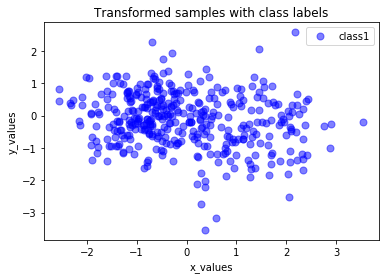

In [140]:
plt.plot(transformed[0], transformed[1], 'o', 
         markersize=7, color='blue', alpha=0.5, label='class1')


plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('Transformed samples with class labels')

plt.show()

In [71]:
%pylab inline

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch


class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

mean_x = np.mean(xyz_std[0,:])
mean_y = np.mean(xyz_std[1,:])
mean_z = np.mean(xyz_std[2,:])

ax.plot(xyz_std[0,:], xyz_std[1,:], xyz_std[2,:], 'o', markersize=8, color='green', alpha=0.2)
ax.plot([mean_x], [mean_y], [mean_z], 'o', markersize=10, color='red', alpha=0.5)
for v in eig_vec_sc.T:
    a = Arrow3D([mean_x, v[0]], [mean_y, v[1]], [mean_z, v[2]], mutation_scale=20, 
                lw=3, arrowstyle="-|>", color="r")
    ax.add_artist(a)
ax.set_xlabel('x_values')
ax.set_ylabel('y_values')
ax.set_zlabel('z_values')

plt.title('Eigenvectors')

plt.show()

Populating the interactive namespace from numpy and matplotlib


TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

<Figure size 504x504 with 1 Axes>

In [74]:
type(xyz_std[0,1])

numpy.float64